### do gen-matching with delphes root files

In [1]:
#env : Lpr

In [2]:
import uproot
import awkward as ak

from glob import glob
from coffea.nanoevents import NanoEventsFactory, DelphesSchema

# from coffea import nanoevents
# from coffea.nanoevents.methods.base import NanoEventsArray
# from coffea.analysis_tools import Weights, PackedSelection
# from coffea.nanoevents.methods import nanoaod
# from coffea.nanoevents.methods import vector
# from coffea.lookup_tools.dense_lookup import dense_lookup
# from coffea.nanoevents.methods.nanoaod import MuonArray, JetArray, FatJetArray, GenParticleArray
# ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict, Tuple
from copy import copy

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

from tqdm import tqdm

# import fastjet

import pathlib

# import jetnet

import os

import boost_histogram as bh
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [3]:
plot_dir = "../plots/piechart/30Sep2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
# load the slimmedtree files using uproot
# if run on PKU cluster, use this:
CustNanoData = {
    'TT_Semilep'         :"/data/bond/zhaoyz/Pheno/slimmedtree/v7/TTbar_semilep.root",
}
files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

### Investigate jet information

In [5]:
events = files["TT_Semilep"]


In [10]:
match_dict = {
    "top(t->bqq)": events["top_matched_bqq"],
    "top(t->bq)" : events["top_matched_bq"],
        
    r"$b_{lep}qq$": events["lep_b_qq"],
    r"$b_{lep}q$" : events["lep_b_q"],
    
    "W_matched(W->cd)"   : events["w_matched_cd"],
    "W_matched(W->cs)"   : events["w_matched_cs"],
    "W_matched(W->cb)"   : events["w_matched_cb"],
    "W_matched(W->ud)"   : events["w_matched_ud"],
    "W_matched(W->ub)"   : events["w_matched_ub"],
    "W_matched(W->us)"   : events["w_matched_us"],
    
    r"$b_{had}$"   : events["b_matched_had"],
    r"$b_{lep}$"   : events["b_matched_lep"],
    
    r"$b_{lep}b_{had}$"       : events["bb_matched"],
    r"$b_{lep}b_{had}q$"   : events["bb_q"],
    r"$b_{lep}b_{had}qq$"   : events["bb_qq"],
    
    "q"   : events["q_matched"],
    
    "unmatched"          : events["unmatched"],
}

In [14]:
labels = list(set(labels))
labels

['$b_{had}$',
 'q',
 'unmatched',
 '$b_{lep}q$',
 'top(t->bq)',
 '$b_{lep}b_{had}$',
 'top(t->bqq)',
 '$b_{lep}$',
 '$b_{lep}b_{had}qq$',
 '$b_{lep}qq$',
 '$b_{lep}b_{had}q$',
 'W']

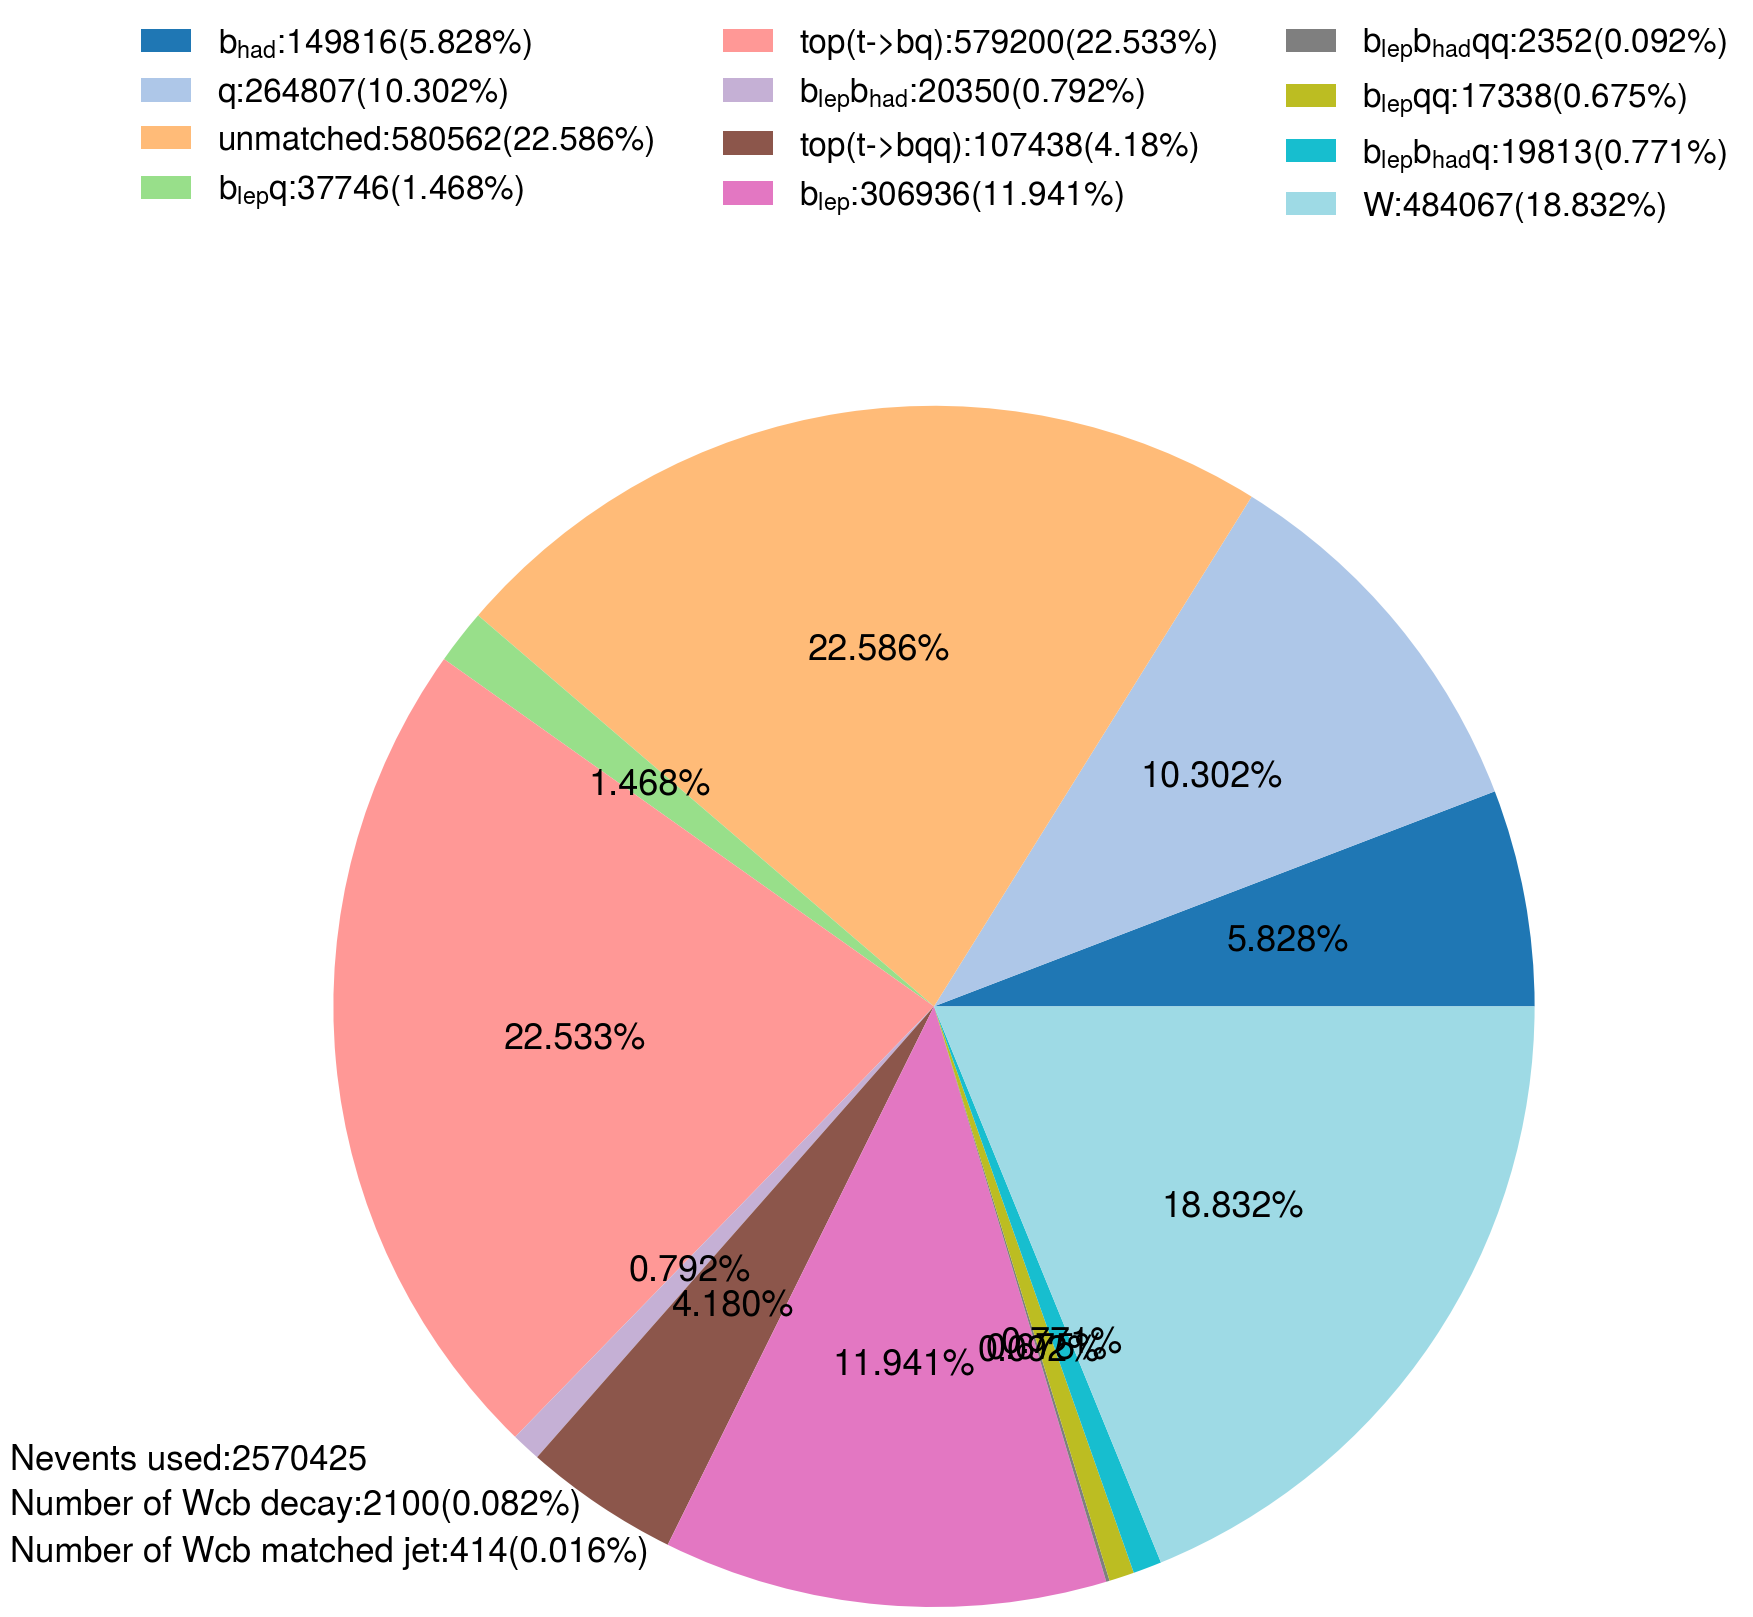

In [15]:
# make a pie-chart to visulize the fraction
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

plt.figure(figsize=(15,15))
ax=plt.gca()
plt.grid()

np.random.seed(42)
colors = plt.cm.tab20(np.linspace(0, 1, 12))

W_matched_num = 0
for match_type in match_dict:
    if match_type.startswith("W_matched"):
        W_matched_num += np.sum(match_dict[match_type])

labels = []
for key in match_dict:
    if not key.startswith("W_matched") : 
        labels.append(key)
    else:
        labels.append("W")

# labels = list(set(labels))    
labels = ['$b_{had}$',
 'q',
 'unmatched',
 '$b_{lep}q$',
 'top(t->bq)',
 '$b_{lep}b_{had}$',
 'top(t->bqq)',
 '$b_{lep}$',
 '$b_{lep}b_{had}qq$',
 '$b_{lep}qq$',
 '$b_{lep}b_{had}q$',
 'W']    
       

# labels = ['top_matched(t->bqq)', 'top_matched(t->bq)', 'W_matched', "lep.b + W_matched", "lep.b + q_matched" ,"b_matched(had.t)", "b_matched(lep.t)","bb_matched","bb + q_matched","bb + W_matched", "q_matched(had.W)",'unmatched']

sizes = []
len_n = len(match_dict["unmatched"])
labels_with_num = []
for label in labels:
    if not label == "W":
        size_to_add = np.sum(match_dict[label])
        sizes.append(size_to_add)
        labels_with_num.append(label + ":"  + str(np.sum(match_dict[label])) + "(" + str(round(np.sum(match_dict[label])*100/len_n,3)) + "%)")
    else:
        size_to_add = W_matched_num
        sizes.append(size_to_add)
        labels_with_num.append(label + ":"  + str(size_to_add) + "(" + str(round(size_to_add*100/len_n,3)) + "%)")
# colors = ['#ffff00', '#2ca02c', '#ff7f0e', '#800080','red']
# highlight some component(optional)
explode = (0., 0, 0, 0, 0, 0,0,0,0,0, 0,0)
# plot the pie chat
plt.pie(sizes, labels=None, autopct='%1.3f%%', startangle=0, explode=explode, radius=1.3, colors = colors)
plt.legend(labels_with_num, loc='lower center',fontsize = 24, ncol =3, bbox_to_anchor=(0.5, 1.15))
# set title
# plt.title(r'$\ \ Signal' + "" + r'\ jet_{a}\ decomposition $',fontsize = 30)
# plt.title("ttbar(semi-lep) samples Wcb candidate jet decomposition", fontsize = 25)
# title_text = 'Pie Chart Example'

plt.text(-2,-1, f"Nevents used:{str(len_n)}", fontsize=25)
len_wcb = np.sum(events["isWcb"])
frac_wcb = round(len_wcb*100/len_n,3)
plt.text(-2,-1.1, f"Number of Wcb decay:{str(len_wcb)}({str(frac_wcb)}%)", fontsize=25)
len_wcb_jet = np.sum(events["w_matched_cb"])
frac_wcb_jet = round(len_wcb_jet*100/len_n,3)
plt.text(-2,-1.2, f"Number of Wcb matched jet:{str(len_wcb_jet)}({str(frac_wcb_jet)}%)", fontsize=25)
plt.savefig(f"{plot_dir}/Piechart_"+ "wcb_set" + "_deco.pdf", bbox_inches='tight')
plt.show()


In [8]:
print(labels)

['$b_{had}$', 'q', 'unmatched', '$b_{lep}q$', 'top(t->bq)', '$b_{lep}b_{had}$', 'top(t->bqq)', '$b_{lep}$', '$b_{lep}b_{had}qq$', '$b_{lep}qq$', '$b_{lep}b_{had}q$', 'W']


In [9]:
print(len(labels))

12
